In [145]:
#imports base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import seaborn as sns
import warnings
#from src.utils import *

#sklearn utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

#models
from sklearn.cluster import KMeans

In [146]:
#configuracion
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("PuBuGn_d"))
warnings.filterwarnings('ignore')
sys.path.append('/home/ubuntu/fastai/fastai/')
%matplotlib inline

#pathdata
PATH_DATA = '/home/ubuntu/fastai/data/'

In [147]:
#lectura dataset
df = pd.read_table(PATH_DATA+'/TRAIN.txt', sep=',')
df.head()

,ID_Customer,Imp_Cons_01,Imp_Cons_02,Imp_Cons_03,Imp_Cons_04,Imp_Cons_05,Imp_Cons_06,Imp_Cons_07,Imp_Cons_08,Imp_Cons_09,...,Num_Oper_17,Num_Oper_18,Num_Oper_19,Num_Oper_20,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_04,Socio_Demo_05,Poder_Adquisitivo
0,TR000001,0.0,0.00,0.000000,63.067778,0.0,52.196667,0.0,0.000000,0.00,...,2,0,0,0,09991,1,70.44,3,20,19709.915000
1,TR000002,0.0,100.58,595.454545,10.899000,0.0,39.473636,0.0,62.268571,42.61,...,4,1,0,0,09991,2,71.87,3,29,37497.492167
2,TR000003,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,...,2,0,0,0,0X301,2,72.48,2,41,4802.970000
3,TR000004,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,...,0,0,0,0,0X301,2,86.60,3,38,8295.770000
4,TR000005,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00,...,0,0,0,0,09991,2,92.48,4,35,24149.321667


In [148]:
#conteo de clientes diferentes en el conjunto de entrenamiento.
nclientes_train = df.shape[0]
nclientes_train

363834

In [149]:
#definición variables TARGET categóricas, binarias y numéricas:
TARGET           = 'Poder_Adquisitivo'
binary_vars      = ['Socio_Demo_01', 'Socio_Demo_02']
categorical_vars = ['Ind_Prod_%(#)02d'% {"#":x} for x in range(1, 25) ] + binary_vars
numerical_vars   = sorted(list(set(df.columns) - set([TARGET]) - set(categorical_vars) - set(binary_vars) - set(['ID_Customer'])))

In [150]:
#nos aseguramos que las numéricas están bien formateadas
df[numerical_vars] = df[numerical_vars].apply(pd.to_numeric, errors='ignore')
#formateo variables categoricas
for col in categorical_vars: df[col] = df[col].astype('category').cat.as_ordered()

## EDA 

Vamos a analizar las variables numéricas en primer lugar. 

Para ello vamos a generar un informe con los parámetros básicos de cada variable (conteos, medias, cuartiles, ...) y un histograma de cada variable.

Esto nos permitirá identificar a primera vista la distribución que tiene cada variable y la posible presencia de *outliers*.

Analicemos la variable `TARGET`

In [ ]:
#información estadística relevante del cliente
df[TARGET].describe()

El poder adquisitivo medio ronda los 16K. Sin embargo, existe una gran asimetría con clientes con un poder adquisitivo varios órdenes de magnitud mayor.

In [ ]:
#diagrama de densidad del poder adquisitivo
sns.distplot(df[TARGET])

In [ ]:
#diagrama de densidada del poder adquisitivo
sns.distplot(np.log(df[TARGET]), color='#009999')

Observamos que la transformación logarítmica beneficia enormemente la representabilidad de la distribución del `TARGET`.

A continuación extraemos la misma información para el resto de variables numéricas.

In [ ]:
#lista de descripciones estadísticas e histogramas de las variables numéricas
start_time = time.time()

for i, var in enumerate(sorted(numerical_vars)):
    print(df[numerical_vars[i]].describe())
    plt.hist(df[numerical_vars[i]], bins= 1000, color='#009999')
    plt.xlabel('units')
    plt.ylabel('count')
    plt.title('distribución variable : {0}'.format(var))
    plt.show()
    print('\n')
    
print("--- %s seconds ---" % (time.time() - start_time))

---
A continuación vamos a realizar el análisis exploratorio de las variables categóricas.

Éste consistirá en obtener los conteos del número de clientes en cada conjunto para cada categoría; así como obtener un *box-plot* de cada categoría frente al `TARGET` (con el $log$ aplicado).

In [ ]:
#lista de descriptivos y boxplots de las variables numéricas
start_time = time.time()

for i, var in enumerate(sorted(categorical_vars)):
    print(df[var].describe())
    dataplot = pd.concat([np.log(df[TARGET]), df[var]], axis=1)
    f, ax = plt.subplots(figsize=(8, 6))
    fig = sns.boxplot(x=var, y=TARGET, data=dataplot)
    fig.axis(ymin=0);
    print('\n')
    
print("--- %s seconds ---" % (time.time() - start_time))

Salvo la variable `Socio_Demo_01`, el resto de variables tiene un número de categorías bajo (3 la mayoría). Esto facilita su tratamiento, ya que consiguen agrupar un % alto de clientes cada categoría.

La variable `Socio_Demo_01` que es una variable discreta pero con un número muy alto de valores (921) por lo que requiere un tratamiento especial.

In [151]:
df['Socio_Demo_01_mod'] = df['Socio_Demo_01'].replace([np.inf, -np.inf, np.nan], '-99')
conditions = [
    (df['Socio_Demo_01_mod'] == '0X301'),
    #(type(df['Socio_Demo_01']) is not int) & (df['Socio_Demo_01'] != '0X301'),
    (df['Socio_Demo_01_mod'] != '0X301')
]
choices = [
    0, 
    df['Socio_Demo_01_mod']
]
df['Socio_Demo_01_mod'] = np.select(conditions, choices)
df['Socio_Demo_01_mod'] = np.int32(pd.to_numeric(df['Socio_Demo_01_mod']))
df['Socio_Demo_01_mod'] = df['Socio_Demo_01_mod'].astype('category').cat.as_ordered()

In [152]:
Socio_Demo_01_df = df.groupby(['Socio_Demo_01_mod']).agg({TARGET: [min, max, 'mean', 'std', 'median'], 'Socio_Demo_01_mod': ['size']})
#Socio_Demo_01_df.head()

In [153]:
Kmeans_socio_demo = KMeans(n_clusters=50,random_state=42)
scaler = preprocessing.StandardScaler()

In [154]:
Socio_Demo_01_X = Socio_Demo_01_df.replace([np.inf, -np.inf,  np.nan], 0)
Socio_Demo_01_X = scaler.fit_transform(Socio_Demo_01_X)
clusters = list(Kmeans_socio_demo.fit_predict(Socio_Demo_01_X))

In [155]:
Socio_Demo_01_df['cluster'] = clusters

In [156]:
Socio_Demo_01_df = Socio_Demo_01_df[['cluster']]
Socio_Demo_01_df = Socio_Demo_01_df.reset_index()

In [157]:
df = pd.merge(df, Socio_Demo_01_df, on='Socio_Demo_01_mod', how='left')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


In [158]:
df['cluster_Social_Demo_01'] = df[('cluster', '')].astype('category').cat.as_ordered()
df = df.drop([('cluster', ''), 'Socio_Demo_01_mod', 'Socio_Demo_01'], axis=1)

In [159]:
categorical_vars.append('cluster_Social_Demo_01')
categorical_vars = list(set(categorical_vars) - set(['Socio_Demo_01']))

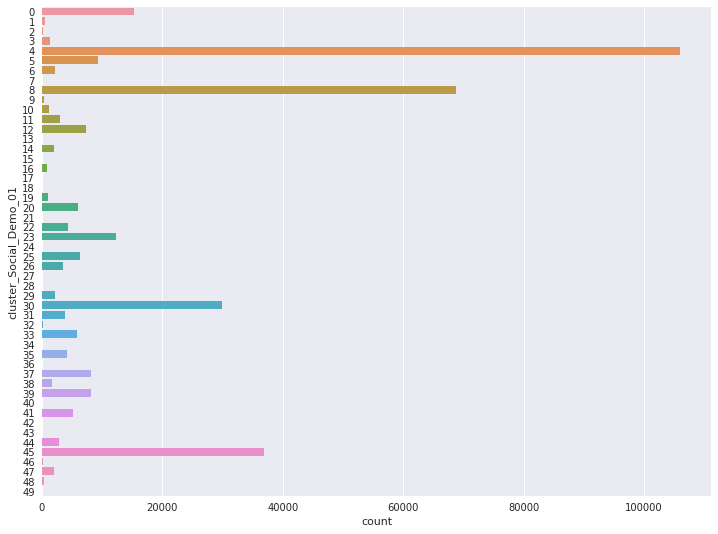

In [138]:
dataplot = pd.concat([np.log(df[TARGET]), df['cluster_Social_Demo_01']], axis=1)
f, ax = plt.subplots(figsize=(12, 9))
fig = sns.countplot(y='cluster_Social_Demo_01', data=dataplot)


----

# Transformación de variables contínuas

Por los *summary* queda claro que existen varios clientes en cada una de las variables que se salen de los cuartiles generales. Puesto que se trata de un tablón con información económica, estos clientes no son necesariamente "outliers", si no que puede tratarse de personas de renta alta/muy alta.

Aquellos clientes que detectemos que exceden el tercer cuartil en un número "alto". Los vamos a marcar con una variable categórica para que el modelo sea capaz de detectar que son clientes "especiales".

La variable `Socio_Demo_05` muestra un valor normal por lo que lo vamos a tratar. El resto de variables las vamos a "normalizar" aplicando el logaritmo.

In [22]:
idx_specials = sorted(list(set(
    [item for sublist in 
     [
         outliers_score(df[numerical_vars[i]])[0].tolist() 
         for i, var in enumerate(list( set(numerical_vars)-set(['Socio_Demo_05']) )) 
     ]  
     for item in sublist])))

NameError: name 'outliers_score' is not defined

In [22]:
#número de clientes "especiales"
df.iloc[idx_specials].shape[0]

45945

In [23]:
#creamos la variable "cliente especial".
df['cliente_especial'] = 'NO'
df.loc[idx_specials, ['cliente_especial']]='SI'

df['cliente_especial'] = df['cliente_especial'] .astype('category').cat.as_ordered()
categorical_vars.append('cliente_especial')

En los *summary* de arriba podemos observar que existe alguna variable cuyo mínimo es menor que 0. Estas variables no pueden transformarse por el $log$, por lo que las excluiremos.

Adicionalmente excluiremos las variables `Num_Oper_`, ya que representan conteos de operaciones y la diferencia entre el máximo y mínimo escala no excede los 3 órdenes de magnitud .

**Importante**: La variable `TARGET` también tiene una distribución poco simétrica (más "*poissonica*" que normal). Debido a que ciertos algoritmos y modelos estadísticos se van a beneficiar de la normalización de la variable le aplicaremos el logaritmo también. Esto implica que el modelo estimará el $log(poderAdquisitivo)$ y tendremos que invertir la transformación para la evaluación de la capacidad predictiva.

In [160]:
vars_2_exclude   = df[numerical_vars].loc[:, df[numerical_vars].apply(lambda x: x < 0).apply(any)].columns.tolist()
numerical_vars.append(TARGET)
vars_2_transform = set(numerical_vars) - set(['Socio_Demo_05']) -set(vars_2_exclude) - set([s for s in numerical_vars if "Num_Oper_" in s])
df_mod = df

for var in vars_2_transform: 
    df_mod[var] = df_mod[var].apply(lambda x: np.log(x + 1))

count    363834.000000
mean          1.366350
std           1.882809
min           0.000000
25%           0.000000
50%           0.000000
75%           3.644808
max           7.886123
Name: Imp_Cons_01, dtype: float64


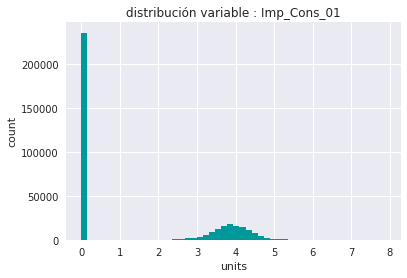



count    363834.000000
mean          2.117492
std           2.297952
min           0.000000
25%           0.000000
50%           0.000000
75%           4.444047
max           9.956949
Name: Imp_Cons_02, dtype: float64


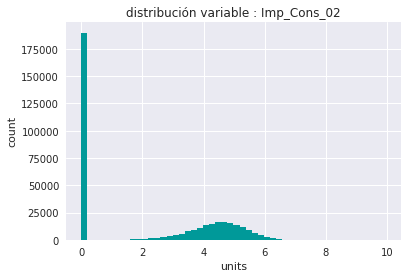



count    363834.000000
mean          3.146737
std           2.961956
min           0.000000
25%           0.000000
50%           4.564348
75%           5.993961
max          10.344352
Name: Imp_Cons_03, dtype: float64


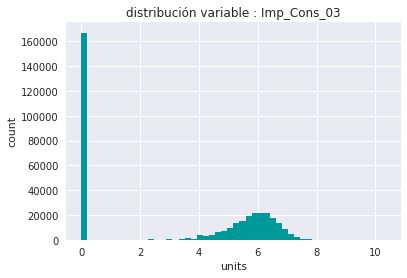



count    363834.000000
mean          1.937308
std           1.869762
min           0.000000
25%           0.000000
50%           2.624563
75%           3.713084
max           7.636191
Name: Imp_Cons_04, dtype: float64


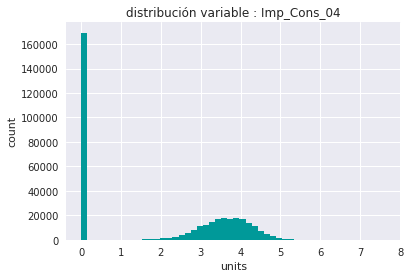



count    363834.000000
mean          0.283715
std           1.088787
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.390660
Name: Imp_Cons_05, dtype: float64


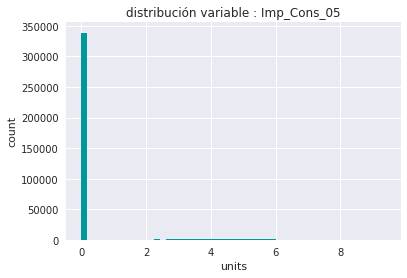



count    363834.000000
mean          1.834203
std           2.055665
min           0.000000
25%           0.000000
50%           0.000000
75%           3.971832
max           8.761539
Name: Imp_Cons_06, dtype: float64


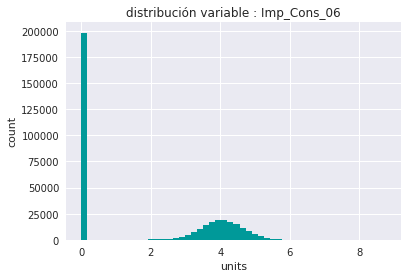



count    363834.000000
mean          0.288420
std           1.054761
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.945081
Name: Imp_Cons_07, dtype: float64


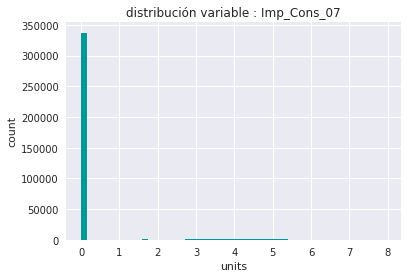



count    363834.000000
mean          1.528908
std           1.963581
min           0.000000
25%           0.000000
50%           0.000000
75%           3.713572
max           9.604067
Name: Imp_Cons_08, dtype: float64


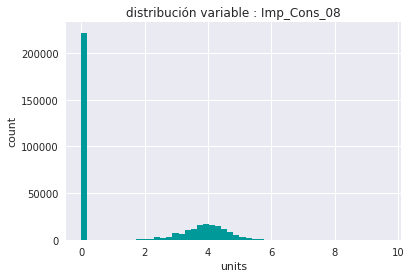



count    363834.000000
mean          1.253077
std           1.885693
min           0.000000
25%           0.000000
50%           0.000000
75%           3.306887
max           8.594770
Name: Imp_Cons_09, dtype: float64


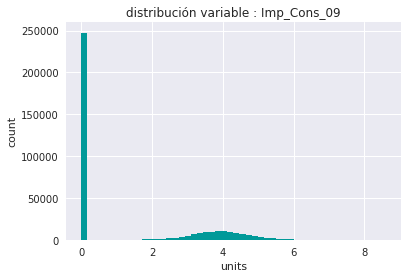



count    363834.000000
mean          0.574461
std           1.379860
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.047939
Name: Imp_Cons_10, dtype: float64


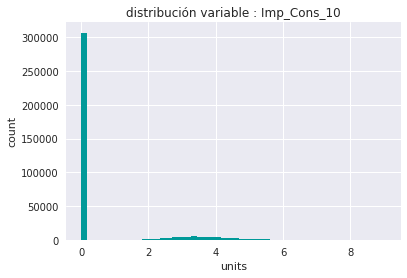



count    363834.000000
mean          1.441404
std           2.553157
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.649971
Name: Imp_Cons_11, dtype: float64


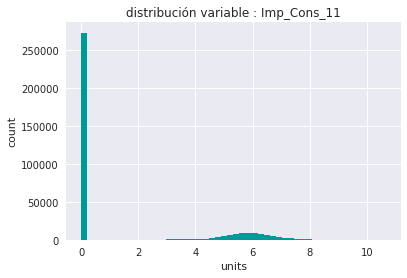



count    363834.000000
mean          2.311155
std           2.971478
min           0.000000
25%           0.000000
50%           0.000000
75%           5.791442
max          10.566736
Name: Imp_Cons_12, dtype: float64


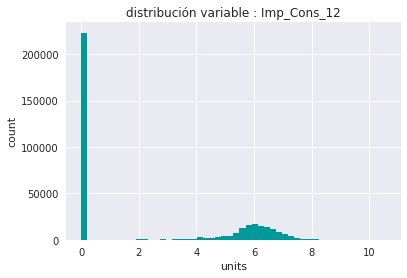



count    363834.000000
mean          0.613174
std           1.578812
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.745611
Name: Imp_Cons_13, dtype: float64


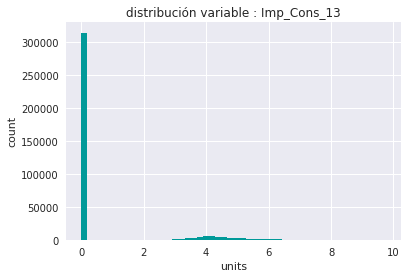



count    363834.000000
mean          0.054161
std           0.459614
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.601182
Name: Imp_Cons_14, dtype: float64


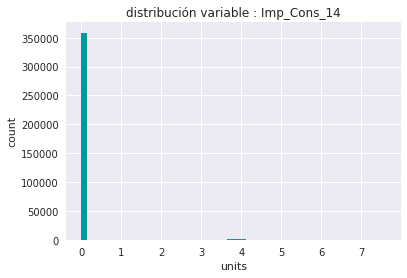



count    363834.000000
mean          2.807729
std           2.442535
min           0.000000
25%           0.000000
50%           3.810859
75%           5.064421
max          11.289794
Name: Imp_Cons_15, dtype: float64


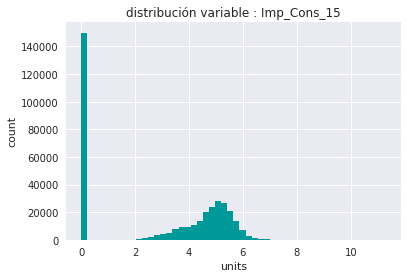



count    363834.000000
mean          1.750680
std           2.141355
min           0.000000
25%           0.000000
50%           0.000000
75%           4.051611
max           9.155638
Name: Imp_Cons_16, dtype: float64


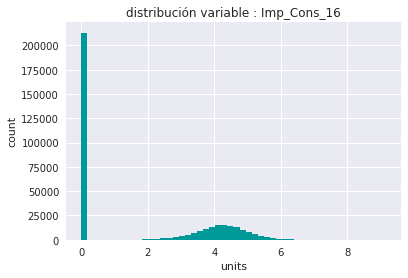



count    363834.000000
mean          0.902117
std           1.912139
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.510502
Name: Imp_Cons_17, dtype: float64


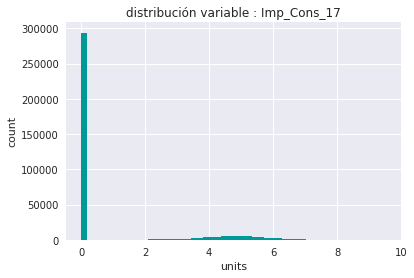



count    363834.000000
mean          0.018800
std           0.393882
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.458837
Name: Imp_Sal_01, dtype: float64


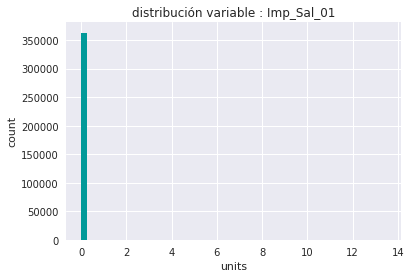



count    363834.000000
mean          1.566043
std           2.658168
min           0.000000
25%           0.000000
50%           0.000000
75%           3.536117
max          15.206462
Name: Imp_Sal_02, dtype: float64


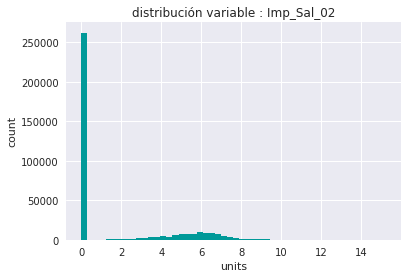



count    363834.000000
mean          0.020355
std           0.404831
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.580759
Name: Imp_Sal_03, dtype: float64


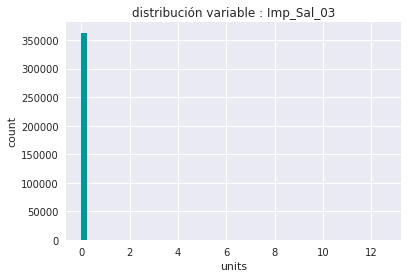



count    3.638340e+05
mean     8.815582e+03
std      3.074944e+04
min     -2.800000e-01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.399320e+06
Name: Imp_Sal_04, dtype: float64


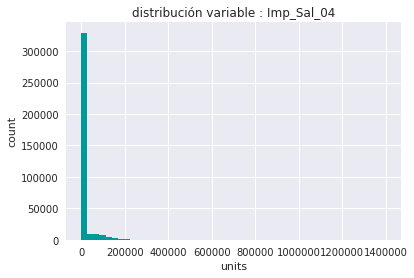



count    363834.000000
mean        593.998464
std        3812.604723
min          -2.360000
25%           0.000000
50%           0.000000
75%           0.000000
max      470486.880000
Name: Imp_Sal_05, dtype: float64


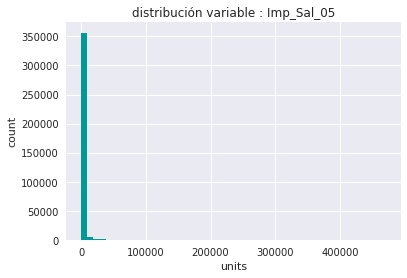



count    363834.000000
mean          0.180833
std           1.276131
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.526949
Name: Imp_Sal_06, dtype: float64


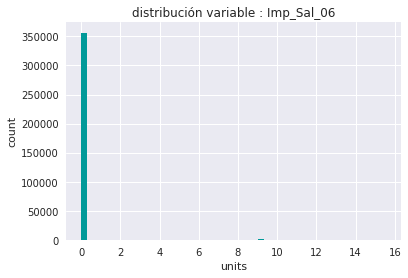



count    363834.000000
mean          0.033570
std           0.519101
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.404039
Name: Imp_Sal_07, dtype: float64


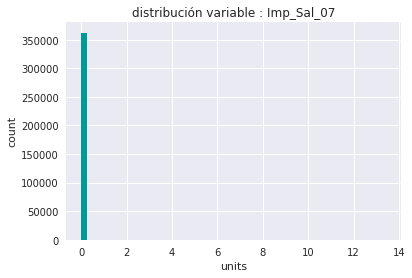



count    363834.000000
mean          6.915439
std           1.482256
min           0.000000
25%           6.479835
50%           7.068450
75%           7.643782
max          13.648925
Name: Imp_Sal_08, dtype: float64


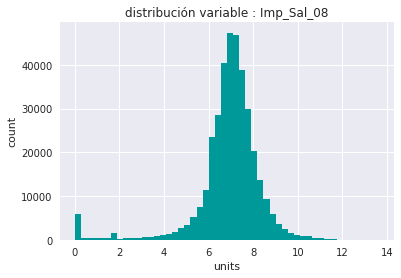



count    363834.000000
mean          6.856082
std           1.583984
min           0.000000
25%           6.486269
50%           7.029669
75%           7.557387
max          14.106490
Name: Imp_Sal_09, dtype: float64


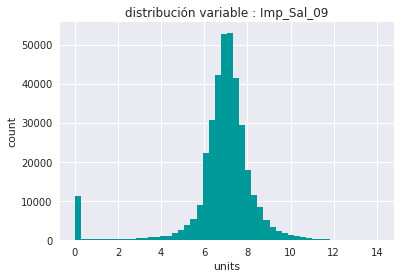



count    363834.000000
mean          4.447209
std           2.450213
min           0.000000
25%           3.651870
50%           5.147901
75%           6.040921
max          15.930888
Name: Imp_Sal_10, dtype: float64


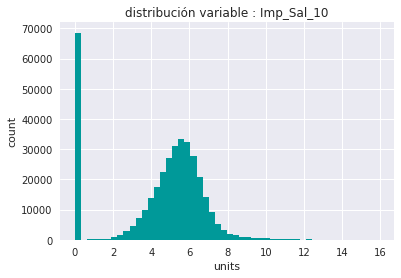



count    363834.000000
mean          0.007292
std           0.262385
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          11.289794
Name: Imp_Sal_11, dtype: float64


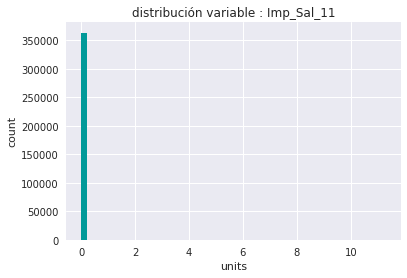



count    363834.000000
mean          0.981434
std           3.056377
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          14.680508
Name: Imp_Sal_12, dtype: float64


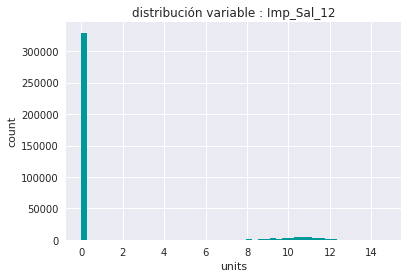



count    363834.000000
mean          0.276616
std           1.640725
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.669766
Name: Imp_Sal_13, dtype: float64


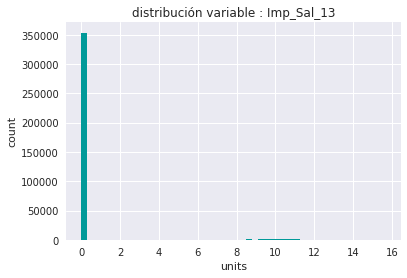



count    363834.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: Imp_Sal_14, dtype: float64


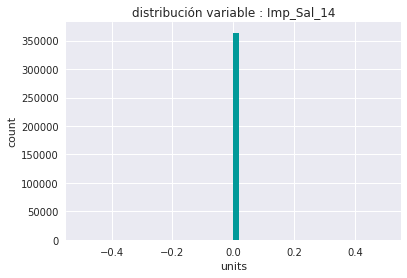



count    363834.000000
mean          1.022050
std           2.231455
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.615825
Name: Imp_Sal_15, dtype: float64


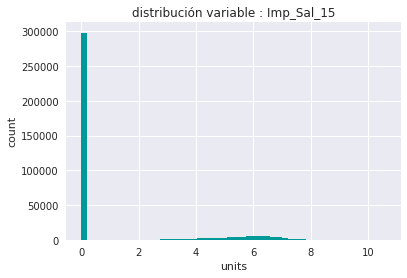



count    363834.000000
mean          2.913613
std           3.123609
min           0.000000
25%           0.000000
50%           0.000000
75%           6.261635
max          10.246018
Name: Imp_Sal_16, dtype: float64


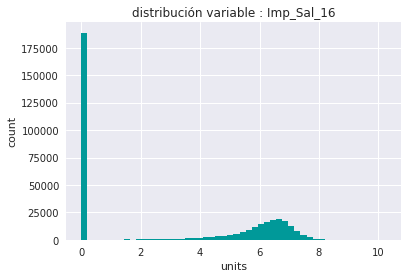



count    363834.000000
mean          0.018950
std           0.343193
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.987983
Name: Imp_Sal_17, dtype: float64


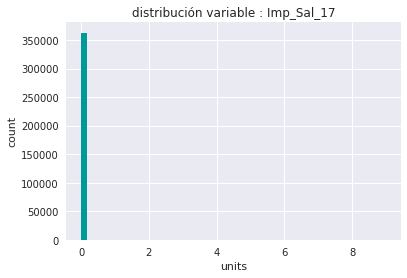



count    363834.000000
mean          0.087442
std           0.864514
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.838497
Name: Imp_Sal_18, dtype: float64


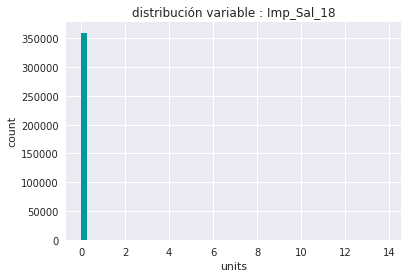



count    3.638340e+05
mean     9.377739e+03
std      2.478623e+04
min     -1.083158e+04
25%      1.590950e+02
50%      1.444545e+03
75%      8.821247e+03
max      3.242860e+06
Name: Imp_Sal_19, dtype: float64


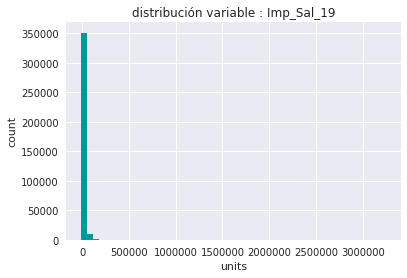



count    363834.000000
mean          3.857998
std           4.254741
min           0.000000
25%           0.000000
50%           0.000000
75%           7.129974
max          15.540725
Name: Imp_Sal_20, dtype: float64


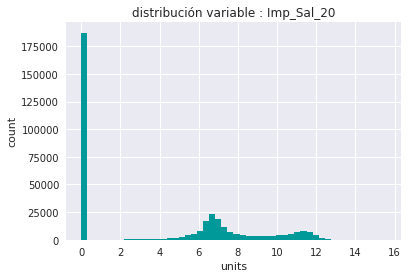



count    363834.000000
mean          7.433453
std           2.705871
min           0.000000
25%           5.588646
50%           7.605270
75%           9.590486
max          15.679653
Name: Imp_Sal_21, dtype: float64


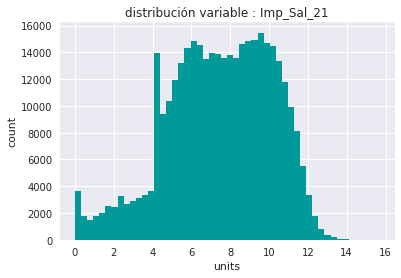



count    363834.000000
mean          0.893902
std           4.231527
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         464.000000
Name: Num_Oper_01, dtype: float64


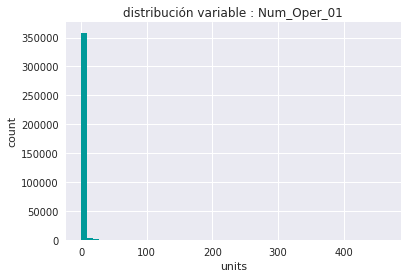



count    363834.000000
mean          1.416915
std           4.789291
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         332.000000
Name: Num_Oper_02, dtype: float64


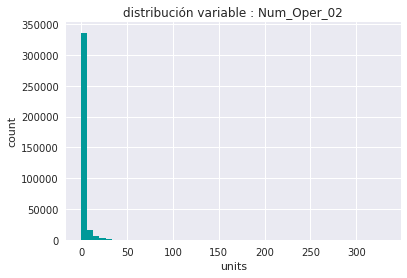



count    363834.000000
mean          5.320195
std           8.995213
min           0.000000
25%           0.000000
50%           0.000000
75%           8.000000
max         239.000000
Name: Num_Oper_03, dtype: float64


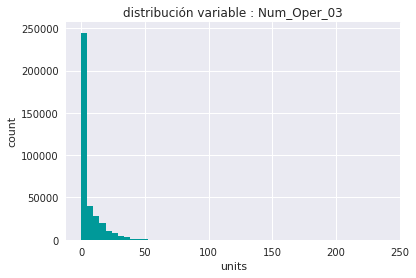



count    363834.000000
mean          0.024687
std           0.664091
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          59.000000
Name: Num_Oper_04, dtype: float64


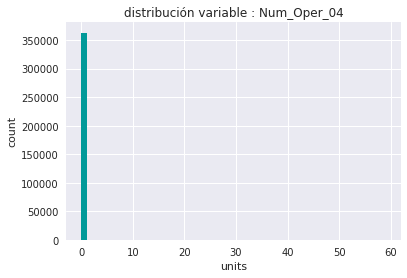



count    363834.000000
mean         14.790492
std          14.357671
min           0.000000
25%           5.000000
50%          10.000000
75%          21.000000
max         606.000000
Name: Num_Oper_05, dtype: float64


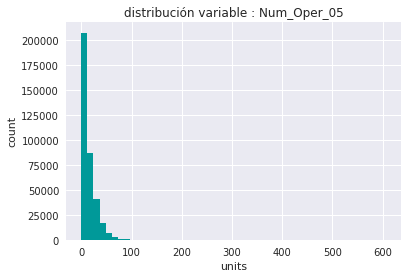



count    363834.000000
mean          2.554687
std           2.712385
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         181.000000
Name: Num_Oper_06, dtype: float64


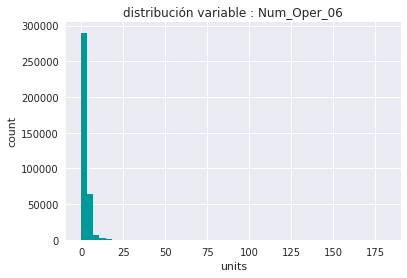



count    363834.000000
mean          0.361536
std           1.720875
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         112.000000
Name: Num_Oper_07, dtype: float64


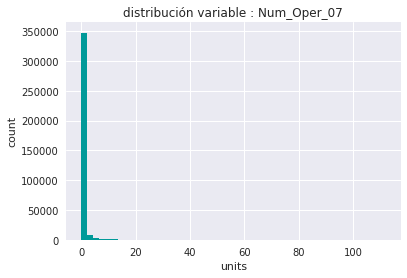



count    363834.000000
mean          1.126857
std           4.150717
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         330.000000
Name: Num_Oper_08, dtype: float64


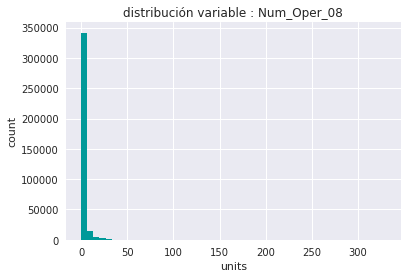



count    363834.000000
mean          2.033518
std           3.874322
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max         154.000000
Name: Num_Oper_09, dtype: float64


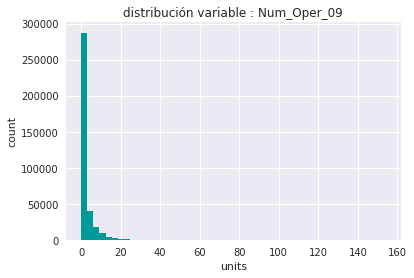



count    363834.000000
mean          3.812500
std           7.334178
min           0.000000
25%           0.000000
50%           0.000000
75%           5.000000
max         236.000000
Name: Num_Oper_10, dtype: float64


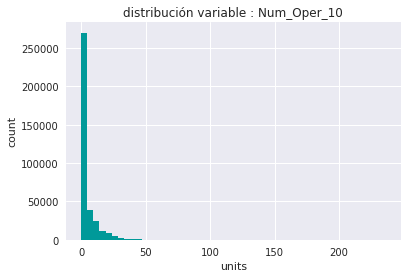



count    363834.000000
mean          0.004219
std           0.181326
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          46.000000
Name: Num_Oper_11, dtype: float64


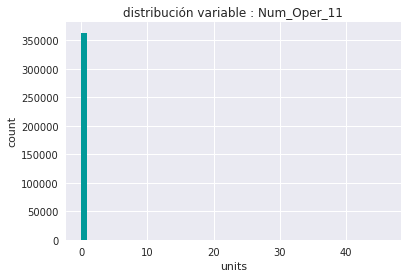



count    363834.000000
mean          0.021433
std           0.601521
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          57.000000
Name: Num_Oper_12, dtype: float64


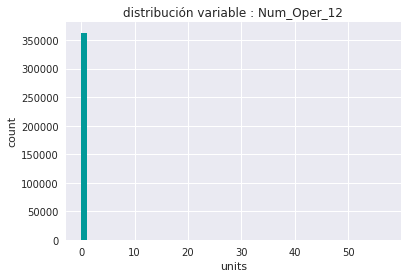



count    363834.000000
mean          1.431991
std           8.405613
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         349.000000
Name: Num_Oper_13, dtype: float64


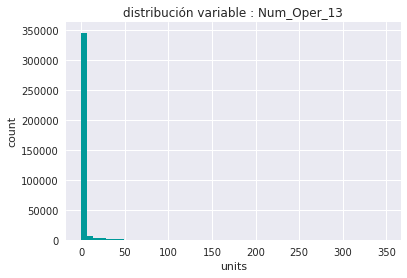



count    363834.000000
mean          0.841419
std           9.076565
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         246.000000
Name: Num_Oper_14, dtype: float64


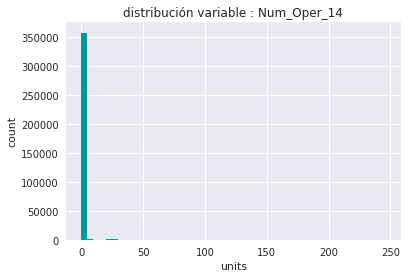



count    363834.000000
mean         13.713039
std          41.192837
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         310.000000
Name: Num_Oper_15, dtype: float64


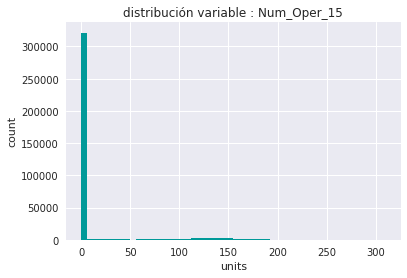



count    363834.000000
mean          0.100309
std           2.512839
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         324.000000
Name: Num_Oper_16, dtype: float64


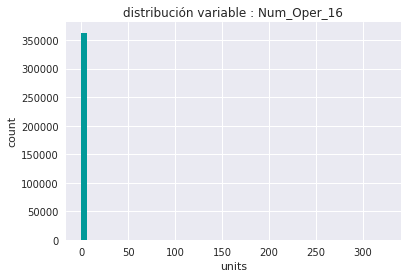



count    363834.000000
mean          4.426870
std          15.891044
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max        1313.000000
Name: Num_Oper_17, dtype: float64


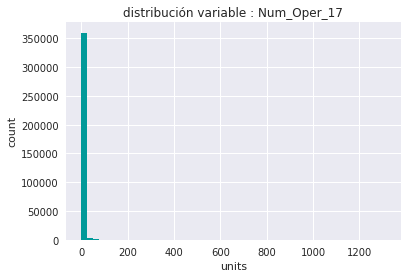



count    363834.000000
mean          0.227200
std           0.455167
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.000000
Name: Num_Oper_18, dtype: float64


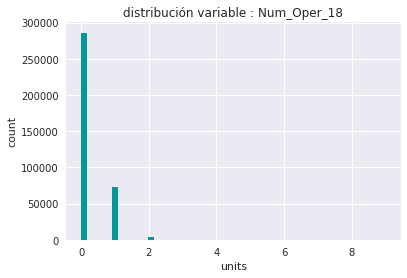



count    363834.000000
mean          0.604512
std           0.643509
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max          34.000000
Name: Num_Oper_19, dtype: float64


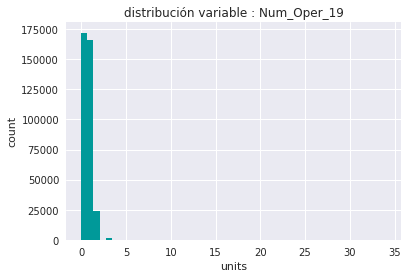



count    363834.000000
mean          0.003919
std           0.063226
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: Num_Oper_20, dtype: float64


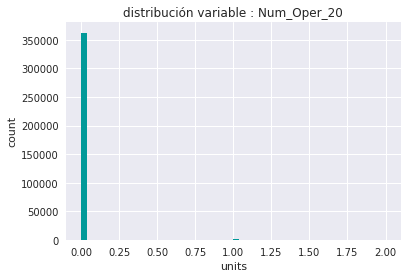



count    363834.000000
mean          3.933194
std           0.394625
min           0.300105
25%           3.672242
50%           3.967458
75%           4.259011
max           4.775588
Name: Socio_Demo_03, dtype: float64


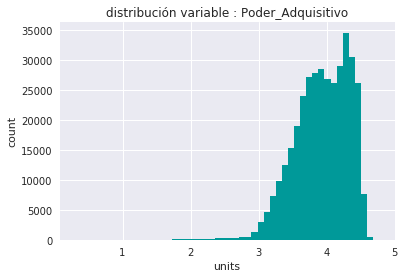



count    363834.000000
mean          1.101599
std           0.414488
min           0.693147
25%           0.693147
50%           1.098612
75%           1.386294
max           8.867568
Name: Socio_Demo_04, dtype: float64


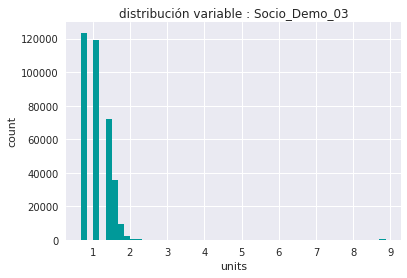



count    363834.000000
mean         18.560715
std          12.404950
min           0.000000
25%          10.000000
50%          17.000000
75%          25.000000
max          58.000000
Name: Socio_Demo_05, dtype: float64


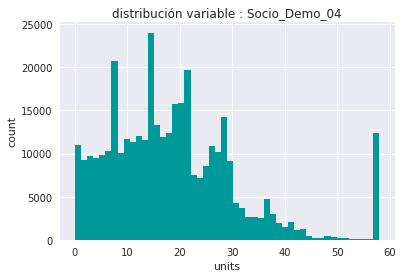



count    363834.000000
mean          9.496946
std           0.584743
min           8.189233
25%           9.137977
50%           9.467009
75%           9.849535
max          15.432917
Name: Poder_Adquisitivo, dtype: float64


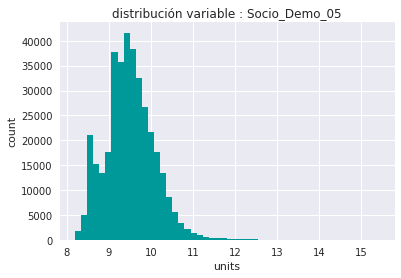



--- 14.092504739761353 seconds ---


In [24]:
start_time = time.time()

for i, var in enumerate(sorted(numerical_vars)):
    print(df[numerical_vars[i]].describe())
    plt.hist(df[numerical_vars[i]], bins= 50, color='#009999')
    plt.xlabel('units')
    plt.ylabel('count')
    plt.title('distribución variable : {0}'.format(var))
    plt.show()
    print('\n')
    
print("--- %s seconds ---" % (time.time() - start_time))

## estudio variables salario

In [139]:
salVars = [s for s in numerical_vars if "Imp_Sal" in s and "Imp_Sal_14" not in s]
salVars

['Imp_Sal_01',
 'Imp_Sal_02',
 'Imp_Sal_03',
 'Imp_Sal_04',
 'Imp_Sal_05',
 'Imp_Sal_06',
 'Imp_Sal_07',
 'Imp_Sal_08',
 'Imp_Sal_09',
 'Imp_Sal_10',
 'Imp_Sal_11',
 'Imp_Sal_12',
 'Imp_Sal_13',
 'Imp_Sal_15',
 'Imp_Sal_16',
 'Imp_Sal_17',
 'Imp_Sal_18',
 'Imp_Sal_19',
 'Imp_Sal_20',
 'Imp_Sal_21']

count    363834.000000
mean          0.018800
std           0.393882
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.458837
Name: Imp_Sal_01, dtype: float64


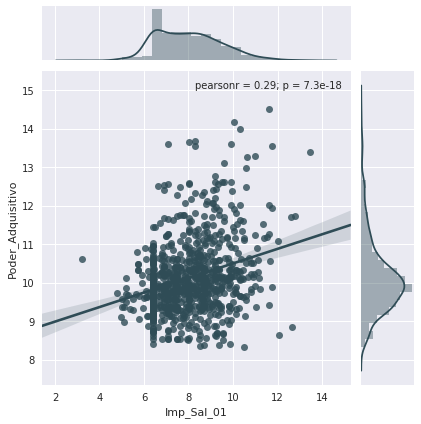



count    363834.000000
mean          1.566043
std           2.658168
min           0.000000
25%           0.000000
50%           0.000000
75%           3.536117
max          15.206462
Name: Imp_Sal_02, dtype: float64


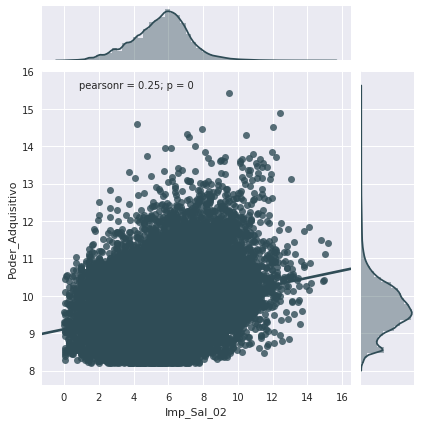



count    363834.000000
mean          0.020355
std           0.404831
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.580759
Name: Imp_Sal_03, dtype: float64


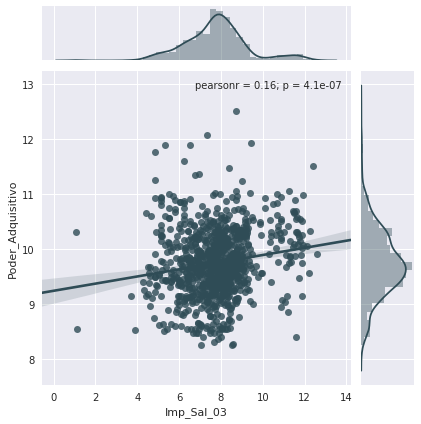



count    3.638340e+05
mean     8.815582e+03
std      3.074944e+04
min     -2.800000e-01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.399320e+06
Name: Imp_Sal_04, dtype: float64


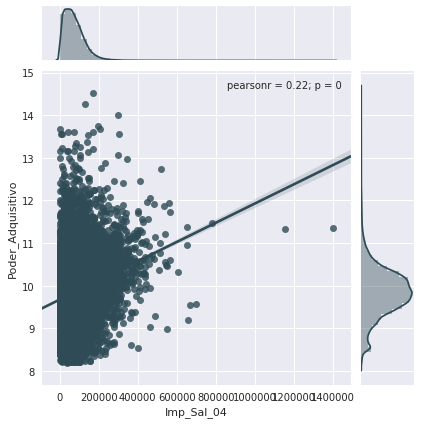



count    363834.000000
mean        593.998464
std        3812.604723
min          -2.360000
25%           0.000000
50%           0.000000
75%           0.000000
max      470486.880000
Name: Imp_Sal_05, dtype: float64


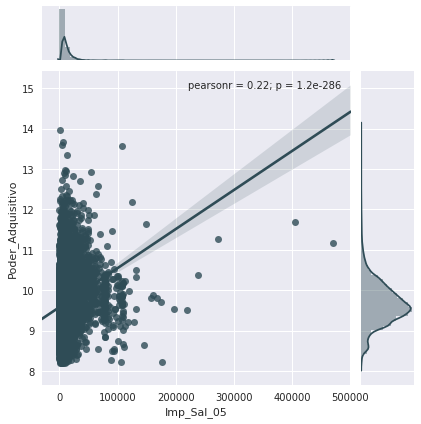



count    363834.000000
mean          0.180833
std           1.276131
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.526949
Name: Imp_Sal_06, dtype: float64


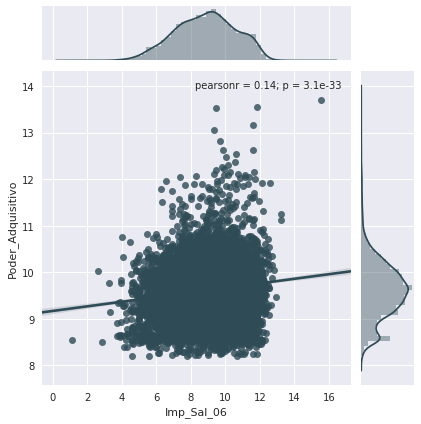



count    363834.000000
mean          0.033570
std           0.519101
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.404039
Name: Imp_Sal_07, dtype: float64


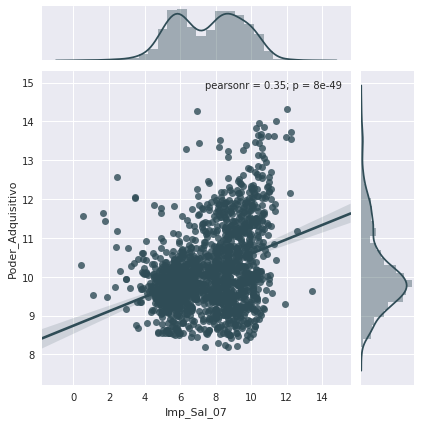



count    363834.000000
mean          6.915439
std           1.482256
min           0.000000
25%           6.479835
50%           7.068450
75%           7.643782
max          13.648925
Name: Imp_Sal_08, dtype: float64


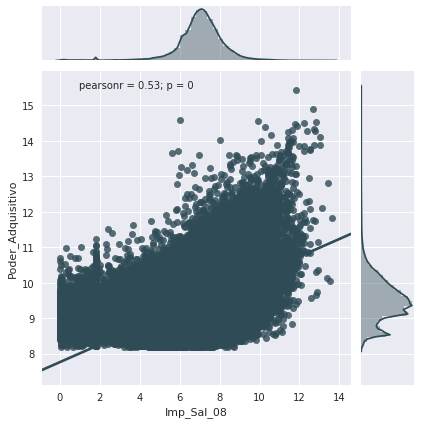



count    363834.000000
mean          6.856082
std           1.583984
min           0.000000
25%           6.486269
50%           7.029669
75%           7.557387
max          14.106490
Name: Imp_Sal_09, dtype: float64


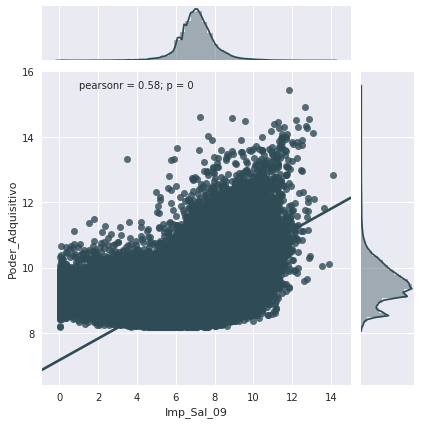



count    363834.000000
mean          4.447209
std           2.450213
min           0.000000
25%           3.651870
50%           5.147901
75%           6.040921
max          15.930888
Name: Imp_Sal_10, dtype: float64


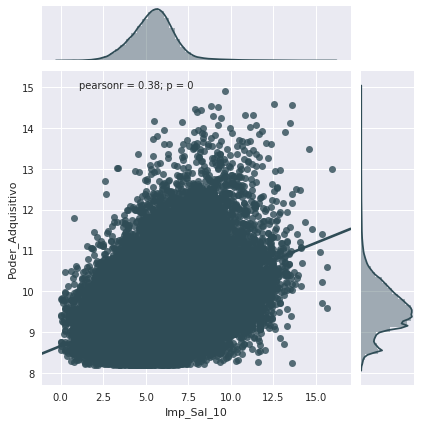



count    363834.000000
mean          0.007292
std           0.262385
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          11.289794
Name: Imp_Sal_11, dtype: float64


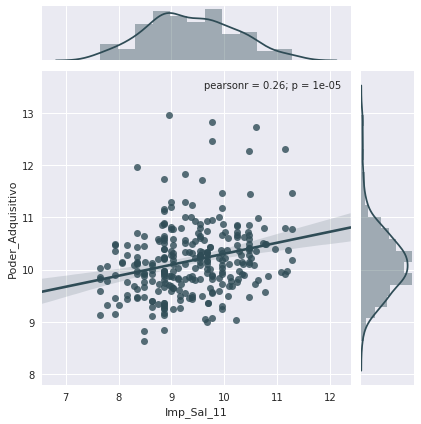



count    363834.000000
mean          0.981434
std           3.056377
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          14.680508
Name: Imp_Sal_12, dtype: float64


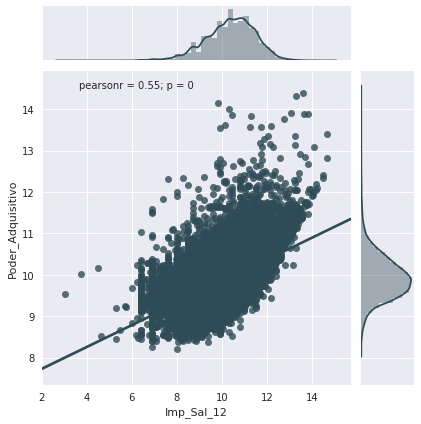



count    363834.000000
mean          0.276616
std           1.640725
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.669766
Name: Imp_Sal_13, dtype: float64


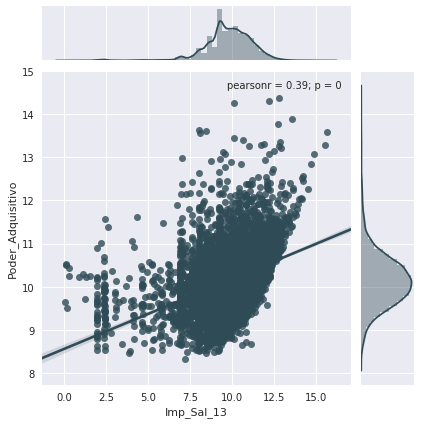



count    363834.000000
mean          1.022050
std           2.231455
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.615825
Name: Imp_Sal_15, dtype: float64


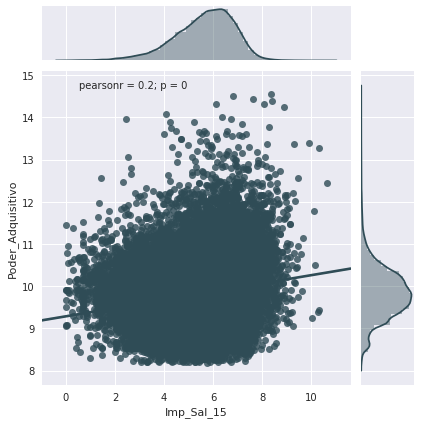



count    363834.000000
mean          2.913613
std           3.123609
min           0.000000
25%           0.000000
50%           0.000000
75%           6.261635
max          10.246018
Name: Imp_Sal_16, dtype: float64


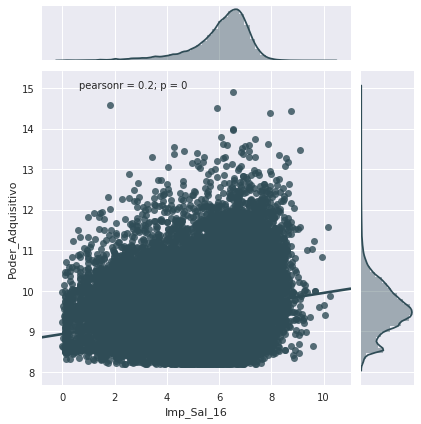



count    363834.000000
mean          0.018950
std           0.343193
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.987983
Name: Imp_Sal_17, dtype: float64


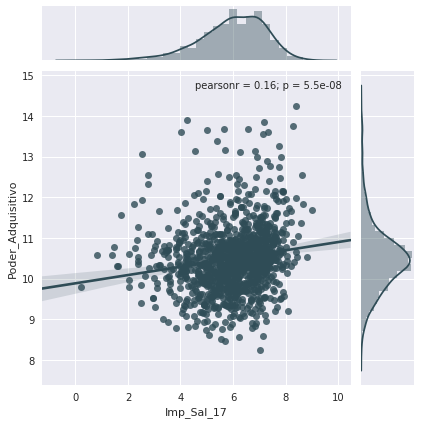



count    363834.000000
mean          0.087442
std           0.864514
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.838497
Name: Imp_Sal_18, dtype: float64


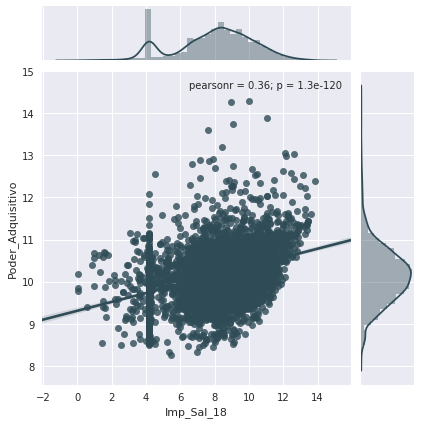



count    3.638340e+05
mean     9.377739e+03
std      2.478623e+04
min     -1.083158e+04
25%      1.590950e+02
50%      1.444545e+03
75%      8.821247e+03
max      3.242860e+06
Name: Imp_Sal_19, dtype: float64


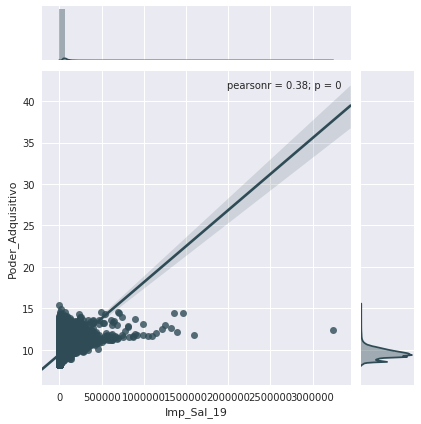



count    363834.000000
mean          3.857998
std           4.254741
min           0.000000
25%           0.000000
50%           0.000000
75%           7.129974
max          15.540725
Name: Imp_Sal_20, dtype: float64


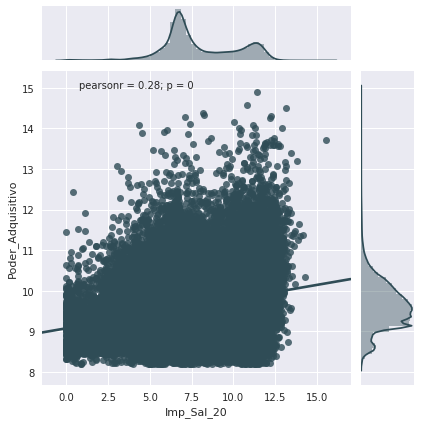



count    363834.000000
mean          7.433453
std           2.705871
min           0.000000
25%           5.588646
50%           7.605270
75%           9.590486
max          15.679653
Name: Imp_Sal_21, dtype: float64


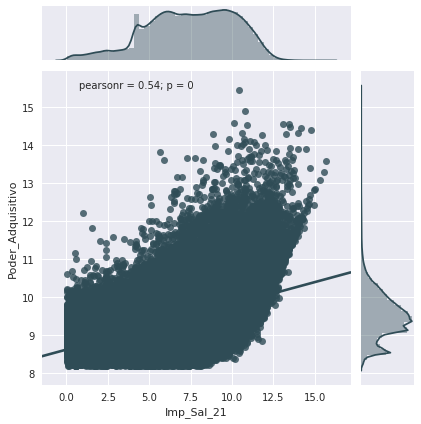



--- 150.10261726379395 seconds ---


In [92]:
start_time = time.time()

for i, var in enumerate(sorted(salVars)):
    print(df[salVars[i]].describe())
    sns.jointplot(x=df[salVars[i]][df[salVars[i]] > 0], y=df[TARGET][df[salVars[i]] > 0], kind = 'reg')
    plt.show()
    print('\n')
    
print("--- %s seconds ---" % (time.time() - start_time))

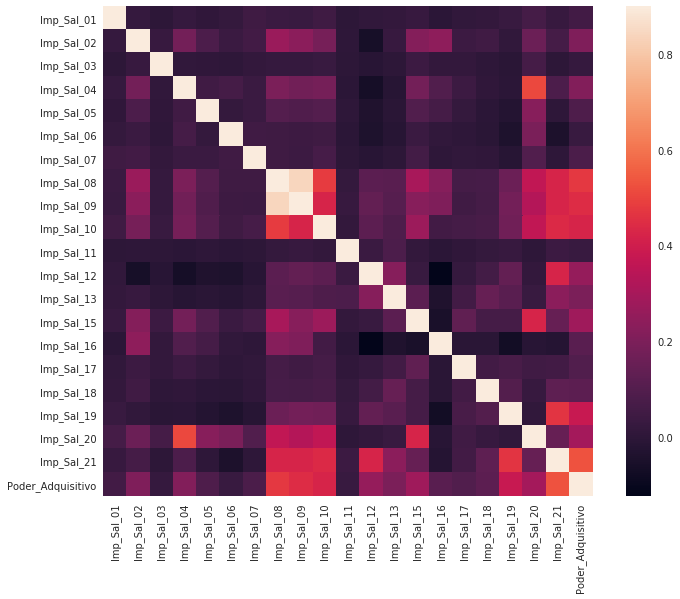

In [103]:
salVars.append(TARGET)
corrmat = df.loc[:, salVars].corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

Con esta información ...

In [161]:
df['Imp_Sal_01'] = pd.cut(df['Imp_Sal_01'], bins=[-np.Inf, 0.01, 7, 11, np.Inf])
df['Imp_Sal_02'] = pd.cut(df['Imp_Sal_02'], bins=[-np.Inf, 0.01, 8, 11, np.Inf])
df['Imp_Sal_03'] = pd.cut(df['Imp_Sal_03'], bins=[-np.Inf, 0.01, 5, 10, np.Inf])
#4 y 5 igual
# 6 la quitamos
df['Imp_Sal_07'] = pd.cut(df['Imp_Sal_07'], bins=[-np.Inf, 0.01, 7, 10, np.Inf])
#8 y 9 tienen una correlación cercana a 1 quitamos a 9 y 8 se queda igual
#10 tambien tiene una correlacion alta con 8. Sin embargo es del 0.5aprox por lo que la discretizamos 
df['Imp_Sal_10'] = pd.cut(df['Imp_Sal_10'], bins=[-np.Inf, 0.01, 5, 8, np.Inf])
#11,12,13 igual
#15,16,17 tienen una forma rara y las quitamos
#18 igual
#19 la discretizamos en 3 bloques
df['Imp_Sal_19'] = pd.cut(df['Imp_Sal_19'], bins=3)
df['Imp_Sal_20'] = pd.cut(df['Imp_Sal_20'], bins=[-np.Inf, 0.01, 5, 8, np.Inf])
#21 igual

impSalConverted = ['Imp_Sal_01', 'Imp_Sal_02', 'Imp_Sal_03', 'Imp_Sal_07', 'Imp_Sal_10', 'Imp_Sal_19', 'Imp_Sal_20']
for v in impSalConverted: categorical_vars.append(v)
numerical_vars = list(set(numerical_vars) - set(impSalConverted))

-------------

# Limpieza de datos

En primer lugar vamos a comprobar que no exista ningún nulo.

# Exportado de datos procesados

A continuación exportamos los datos procesados para ser empleados en posteriores scripts.

In [143]:
import pickle

In [162]:
pickle.dump(df_mod, open('dataframe_processed.pkl','wb'))
pickle.dump((numerical_vars, categorical_vars, TARGET), open('vars.pkl','wb'))